### 2.1 Density Estimation

#### 2.1.1 Temporal Density

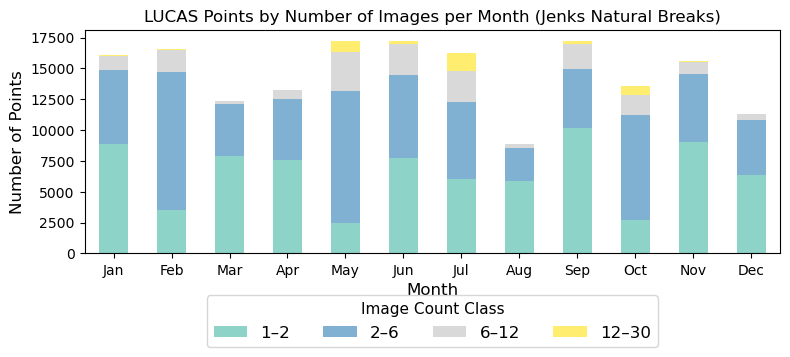

In [1]:
import h5py
import pandas as pd
from datetime import datetime
from collections import defaultdict
import mapclassify
import matplotlib.pyplot as plt

file_path = "United_Kingdom.h5"

# Store counts by (lucas_point, month)
image_counts = defaultdict(int)

with h5py.File(file_path, 'r') as f:
    for key in f.keys():
        if key.startswith("Lucas_Point_"):
            attrs = f[key].attrs
            image_ids = attrs.get("Image_ID", [])
            for img_id in image_ids:
                if isinstance(img_id, bytes):
                    img_id = img_id.decode()
                try:
                    date = datetime.strptime(img_id[:8], "%Y%m%d")
                    month = date.strftime("%Y-%m")
                    image_counts[(key, month)] += 1
                except:
                    continue

# Convert to DataFrame
records = [{"Lucas_Point": k[0], "Month": k[1], "Image_Count": v} for k, v in image_counts.items()]
df = pd.DataFrame(records)

# Apply Jenks Natural Breaks
classifier = mapclassify.NaturalBreaks(y=df["Image_Count"], k=4)
df["Class"] = classifier.find_bin(df["Image_Count"])

# Reconstruct bin labels from classifier.bins
bin_edges = [df["Image_Count"].min()] + list(classifier.bins)
class_labels = [f"{int(bin_edges[i])}–{int(bin_edges[i+1])}" for i in range(len(bin_edges)-1)]

# Convert "Month" to datetime and extract month name
df["Month_Name"] = pd.to_datetime(df["Month"]).dt.strftime("%b")

# Aggregate counts per month and class
agg = df.groupby(["Month_Name", "Class"]).size().unstack(fill_value=0)
month_order = [
    "Jan", "Feb", "Mar", "Apr", "May", "Jun",
    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
]
agg = agg.reindex(month_order)

# Plot
ax = agg.plot(
    kind='bar',
    stacked=True,
    figsize=(8, 4),  # Increased height from 5 → 6
    colormap="Set3"
)

plt.title("LUCAS Points by Number of Images per Month (Jenks Natural Breaks)")
plt.ylabel("Number of Points", fontsize=12)
plt.xlabel("Month", fontsize=12)
plt.xticks(rotation=0)

# Legend placed just inside the top-right, avoiding overlap
plt.legend(
    title="Image Count Class",
    labels=class_labels,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),  # Position below plot
    ncol=len(class_labels),
    frameon=True,
    fontsize=12,
    title_fontsize=11
)

plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leave extra top margin for legend
plt.show()

#### 2.1.2 Spatial Density

/var/folders/z5/zqtg1_hn7_x7fpg92yxfn09r0000gn/T/ipykernel_1878/2827826482.py:92: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap("Set1", len(labels_sorted))
/var/folders/z5/zqtg1_hn7_x7fpg92yxfn09r0000gn/T/ipykernel_1878/2827826482.py:212: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


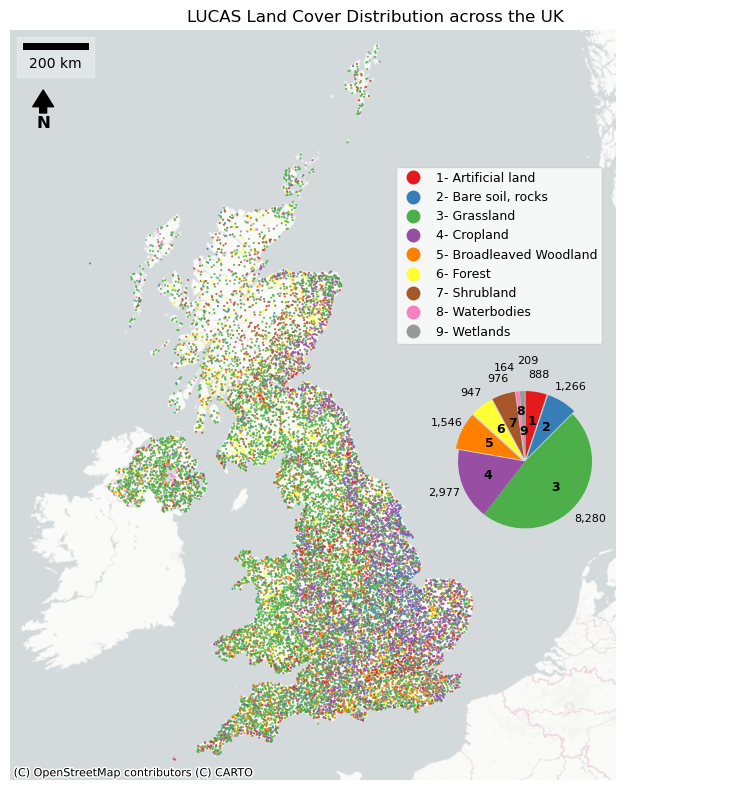

In [3]:
import h5py
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import cm
import numpy as np

def extract_coords_and_labels(h5_file):
    """Extracts lon/lat coordinates and lc1 labels from the HDF5 file."""
    points = []

    with h5py.File(h5_file, 'r') as f:
        for key in f.keys():
            if key.startswith("Lucas_Point_"):
                attrs = f[key].attrs
                coords = attrs.get("Coordinates", None)
                lc1 = attrs.get("lc1", None)  # note lowercase
                
                if coords is not None and lc1 is not None:
                    try:
                        lon, lat = coords  # shapely wants (lon, lat)
                        points.append({
                            "Longitude": lon,
                            "Latitude": lat,
                            "lc1": lc1.decode() if isinstance(lc1, bytes) else str(lc1)
                        })
                    except Exception as e:
                        print(f"Skipping {key} due to error: {e}")

    df = pd.DataFrame(points)
    return df

# Map Lc1 to labels and convert to GeoDataFrame
label_mapping = {
    'A10': 1, 'A11': 1, 'A12': 1, 'A13': 1, 'A20': 1, 'A21': 1, 'A30': 1,
    'A22': 2, 'F10': 2, 'F20': 2, 'F30': 2, 'F40': 2,
    'E10': 3, 'E20': 3, 'E30': 3, 'B50': 3, 'B51': 3, 'B52': 3, 'B53': 3,
    'B54': 3, 'B55': 3,
    'B10': 4, 'B11': 4, 'B12': 4, 'B13': 4, 'B14': 4, 'B15': 4, 'B16': 4,
    'B17': 4, 'B18': 4, 'B19': 4, 'B20': 4, 'B21': 4, 'B22': 4, 'B23': 4,
    'B30': 4, 'B31': 4, 'B32': 4, 'B33': 4, 'B34': 4, 'B35': 4, 'B36': 4,
    'B37': 4, 'B40': 4, 'B41': 4, 'B42': 4, 'B43': 4, 'B44': 4, 'B45': 4,
    'B70': 4, 'B71': 4, 'B72': 4, 'B73': 4, 'B74': 4, 'B75': 4, 'B76': 4,
    'B77': 4, 'B80': 4, 'B81': 4, 'B82': 4, 'B83': 4, 'B84': 4, 'BX1': 4,
    'BX2': 4, 'C10': 5, 'C20': 6, 'C21': 6, 'C22': 6, 'C23': 6, 'C30': 6,
    'C31': 6, 'C32': 6, 'C33': 6, 'CXX1': 6, 'CXX2': 6, 'CXX3': 6,
    'CXX4': 6, 'CXX5': 6, 'CXX6': 6, 'CXX7': 6, 'CXX8': 6, 'CXX9': 6,
    'CXXA': 6, 'CXXB': 6, 'CXXC': 6, 'CXXD': 6, 'CXXE': 6, 'D10': 7,
    'D20': 7, 'G10': 8, 'G11': 8, 'G12': 8, 'G20': 8, 'G21': 8, 'G22': 8,
    'G30': 8, 'G40': 8, 'G50': 8, 'H10': 9, 'H11': 9, 'H12': 9, 'H20': 9,
    'H21': 9, 'H22': 9, 'H23': 9
}

# Map numeric lc1 codes to labels
lc1_labels = {
    1: "1- Artificial land",
    2: "2- Bare soil, rocks",
    3: "3- Grassland",
    4: "4- Cropland",
    5: "5- Broadleaved Woodland",
    6: "6- Forest",
    7: "7- Shrubland",
    8: "8- Waterbodies",
    9: "9- Wetlands"
}

df = extract_coords_and_labels("United_Kingdom.h5")
df["lc1_num"] = df["lc1"].map(label_mapping)
df = df.dropna(subset=["lc1_num"])

# Convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(df["Longitude"], df["Latitude"])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
gdf = gdf.to_crs("EPSG:3857")  # Project to meters
gdf["lc1_label"] = gdf["lc1_num"].map(lc1_labels)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import cm
import numpy as np

# 1. Count and simplify labels to class number only
lc_counts = gdf["lc1_label"].value_counts()
labels_sorted = sorted(lc_counts.index)  # ensures color consistency
label_numbers = [label.split("-")[0].strip() for label in labels_sorted]  # e.g., "1", "2", ...

values_sorted = [lc_counts[label] for label in labels_sorted]

# 2. Assign colors to match map
palette = cm.get_cmap("Set1", len(labels_sorted))
label_color_map = dict(zip(labels_sorted, [palette(i) for i in range(len(labels_sorted))]))
colors = [label_color_map[label] for label in labels_sorted]

# 3. Main map
fig, ax = plt.subplots(figsize=(15, 8))
gdf.plot(
    ax=ax,
    column="lc1_label",
    categorical=True,
    legend=True,
    legend_kwds={'loc': 'center left', 'bbox_to_anchor': (0.52, 0.7), 'fontsize': 9},
    markersize=0.25,
    alpha=1.0,
    cmap="Set1"
)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels)
ax.set_xlim(-1200000, 1000000)
ax.set_ylim(6370000, 8630000)
ax.set_title("LUCAS Land Cover Distribution across the UK")
ax.axis('off')

# 4. Inset pie chart: move slightly lower & centered
inset_ax = inset_axes(ax, width="27%", height="27%", loc='center right', bbox_to_anchor=(-0.02, 0.0, 0.85, 0.85), bbox_transform=ax.transAxes)

# 5. Custom explode for thin slices
explode = [0.05 if v < max(values_sorted)*0.2 else 0 for v in values_sorted]

# 6. Pie chart labels
wedges, texts, autotexts = inset_ax.pie(
    values_sorted,
    labels=None,
    autopct=lambda p: f"{int(round(p * sum(values_sorted) / 100)):,}" if p > 3 else '',  # only label larger slices
    startangle=90,
    counterclock=False,
    colors=colors,
    explode=explode,
    pctdistance=0.75,
    labeldistance=1.05,
    textprops={'fontsize': 9}
)

# Pie chart values
for i, wedge in enumerate(wedges):
    angle = (wedge.theta2 + wedge.theta1) / 2
    x = 0.6 * np.cos(np.deg2rad(angle))
    y = 0.6 * np.sin(np.deg2rad(angle))

    # Nudge label 8 and 9 slightly outward/down
    label = label_numbers[i]
    if label == '8':
        y += 0.15
    elif label == '9':
        y -= 0.15

    inset_ax.text(
        x, y,
        label,
        ha='center',
        va='center',
        fontsize=9,
        fontweight='bold'
    )

# Optional: move autotext (counts) outward a bit more
for autotext, wedge in zip(autotexts, wedges):
    if autotext.get_text():
        angle = (wedge.theta2 + wedge.theta1) / 2
        x = 1.3 * np.cos(np.deg2rad(angle))
        y = 1.3 * np.sin(np.deg2rad(angle))
        autotext.set_position((x, y))
        autotext.set_ha('center')
        autotext.set_va('center')
        autotext.set_fontsize(8)

# Add count labels manually for small slices like 8 and 9
for i, label in enumerate(label_numbers):
    if label in ['8', '9']:
        angle = (wedges[i].theta2 + wedges[i].theta1) / 2
        x = 1.5 * np.cos(np.deg2rad(angle))
        y = 1.5 * np.sin(np.deg2rad(angle))
        
        # Apply small vertical offsets to prevent overlap
        if label == '8':
            x -= 0.15
            y -= 0.1
        elif label == '9':
            x += 0.1

        count = values_sorted[i]

        inset_ax.text(
            x, y,
            f"{count:,}",
            ha='center',
            va='center',
            fontsize=8
        )

from matplotlib.patches import FancyArrow
from matplotlib_scalebar.scalebar import ScaleBar

# scalebar (using matplotlib-scalebar)
scalebar = ScaleBar(1, units='m', dimension='si-length', location='upper left',
                    scale_loc='bottom', length_fraction=0.1, width_fraction=0.01,
                    box_alpha=0.3, pad=0.4, border_pad=0.5)
ax.add_artist(scalebar)

# 2. north arrow
arrow_length = 100000  # in map units (meters); adjust to fit scale
x, y = -1100000, 8450000  # position of the base of the arrow (adjust for your map extent)

ax.annotate('N',
            xy=(x, y),
            xytext=(x, y - arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center',
            fontsize=12, fontweight='bold')


plt.tight_layout()
plt.show()

/var/folders/z5/zqtg1_hn7_x7fpg92yxfn09r0000gn/T/ipykernel_1878/2563155328.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=lc_counts.values, y=lc_counts.index, palette=bar_colors)


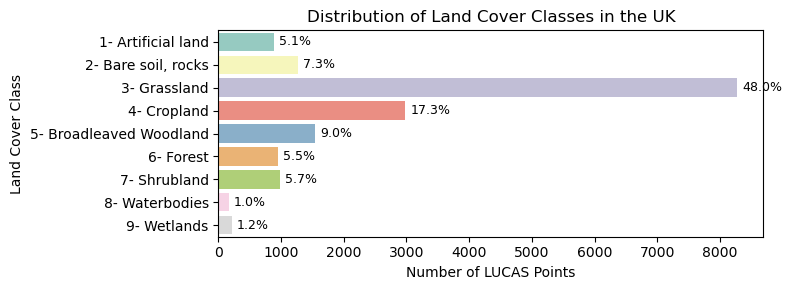

In [4]:
import seaborn as sns

# Define a fixed color palette for lc1 classes using Seaborn
unique_classes = sorted(gdf["lc1_label"].unique())
palette = sns.color_palette("Set3", n_colors=len(unique_classes))
label_colors = dict(zip(unique_classes, palette))
# Count occurrences
lc_counts = gdf["lc1_label"].value_counts().sort_index()
total_count = lc_counts.sum()

# Match colors to class labels
bar_colors = [label_colors[label] for label in lc_counts.index]

# Plot bar chart
plt.figure(figsize=(8, 3))
ax = sns.barplot(x=lc_counts.values, y=lc_counts.index, palette=bar_colors)
# Add percentage labels to the end of each bar
for i, (count, label) in enumerate(zip(lc_counts.values, lc_counts.index)):
    percent = count / total_count * 100
    ax.text(
        count + total_count * 0.005,  # small offset to the right
        i,
        f"{percent:.1f}%",
        va='center',
        fontsize=9
    )
plt.xlabel("Number of LUCAS Points")
plt.ylabel("Land Cover Class")
plt.title("Distribution of Land Cover Classes in the UK")
plt.tight_layout()
plt.show()


✅ Extracted 17253 valid points
   Longitude   Latitude  lc1
0  -6.351084  49.928925  E20
1  -6.317721  49.915431  A11
2  -6.329886  49.950373  G11
3  -8.092840  54.403936  E20
4  -8.108425  54.438570  D10


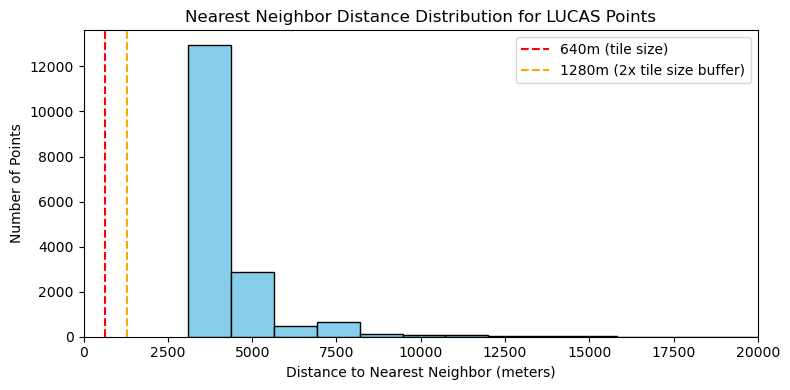

Min distance: 3103.67 m
Points < 640m apart: 0
Points < 1280m apart: 0
Median NN distance: 3405.32 m
Mean NN distance: 3974.60 m


In [1]:
import h5py
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from sklearn.neighbors import BallTree
import numpy as np
import matplotlib.pyplot as plt

def extract_coords_and_labels(h5_file):
    """Extracts lon/lat coordinates and lc1 labels from the HDF5 file."""
    points = []

    with h5py.File(h5_file, 'r') as f:
        for key in f.keys():
            if key.startswith("Lucas_Point_"):
                attrs = f[key].attrs
                coords = attrs.get("Coordinates", None)
                lc1 = attrs.get("lc1", None)  # note lowercase
                
                if coords is not None and lc1 is not None:
                    try:
                        lon, lat = coords  # shapely wants (lon, lat)
                        points.append({
                            "Longitude": lon,
                            "Latitude": lat,
                            "lc1": lc1.decode() if isinstance(lc1, bytes) else str(lc1)
                        })
                    except Exception as e:
                        print(f"Skipping {key} due to error: {e}")

    df = pd.DataFrame(points)
    return df

df = extract_coords_and_labels("United_Kingdom.h5")
print(f"✅ Extracted {len(df)} valid points")
print(df.head())

#  Convert to GeoDataFrame and project to metric CRS
geometry = [Point(xy) for xy in zip(df["Longitude"], df["Latitude"])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
gdf = gdf.to_crs("EPSG:3857")  # metric (meters)

# Extract coordinates for BallTree
coords = np.vstack([gdf.geometry.x, gdf.geometry.y]).T
tree = BallTree(coords, metric='euclidean')

# Query distance to the nearest neighbor (excluding self)
# k=2 returns self (distance=0) + nearest neighbor
distances, _ = tree.query(coords, k=2)
nearest_distances = distances[:, 1]  # exclude self

# Histogram, zoomed in for readability
plt.figure(figsize=(8, 4))
plt.hist(nearest_distances, bins=100, color='skyblue', edgecolor='black')

# Focus on distances below 2km
plt.xlim(0, 20000)

# Reference lines
plt.axvline(640, color='red', linestyle='--', label='640m (tile size)')
plt.axvline(1280, color='orange', linestyle='--', label='1280m (2x tile size buffer)')

plt.xlabel("Distance to Nearest Neighbor (meters)")
plt.ylabel("Number of Points")
plt.title("Nearest Neighbor Distance Distribution for LUCAS Points")
plt.legend()
plt.tight_layout()
plt.show()

# Summary stats
print(f"Min distance: {nearest_distances.min():.2f} m")
print(f"Points < 640m apart: {(nearest_distances < 640).sum()}")
print(f"Points < 1280m apart: {(nearest_distances < 1280).sum()}")
print(f"Median NN distance: {np.median(nearest_distances):.2f} m")
print(f"Mean NN distance: {nearest_distances.mean():.2f} m")


### 2.2 Autocorrelation Analysis

In [12]:
import h5py
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd

def extract_coords_and_labels(h5_file):
    """Extracts lon/lat coordinates and lc1 labels from the HDF5 file."""
    points = []

    with h5py.File(h5_file, 'r') as f:
        for key in f.keys():
            if key.startswith("Lucas_Point_"):
                attrs = f[key].attrs
                coords = attrs.get("Coordinates", None)
                lc1 = attrs.get("lc1", None)  # note lowercase
                
                if coords is not None and lc1 is not None:
                    try:
                        lon, lat = coords  # shapely wants (lon, lat)
                        points.append({
                            "Longitude": lon,
                            "Latitude": lat,
                            "lc1": lc1.decode() if isinstance(lc1, bytes) else str(lc1)
                        })
                    except Exception as e:
                        print(f"Skipping {key} due to error: {e}")

    df = pd.DataFrame(points)
    return df

df = extract_coords_and_labels("United_Kingdom.h5")
print(f"✅ Extracted {len(df)} valid points")
print(df.head())

✅ Extracted 17253 valid points
   Longitude   Latitude  lc1
0  -6.351084  49.928925  E20
1  -6.317721  49.915431  A11
2  -6.329886  49.950373  G11
3  -8.092840  54.403936  E20
4  -8.108425  54.438570  D10


In [13]:
# Map Lc1 to labels and convert to GeoDataFrame
label_mapping = {
    'A10': 1, 'A11': 1, 'A12': 1, 'A13': 1, 'A20': 1, 'A21': 1, 'A30': 1,
    'A22': 2, 'F10': 2, 'F20': 2, 'F30': 2, 'F40': 2,
    'E10': 3, 'E20': 3, 'E30': 3, 'B50': 3, 'B51': 3, 'B52': 3, 'B53': 3,
    'B54': 3, 'B55': 3,
    'B10': 4, 'B11': 4, 'B12': 4, 'B13': 4, 'B14': 4, 'B15': 4, 'B16': 4,
    'B17': 4, 'B18': 4, 'B19': 4, 'B20': 4, 'B21': 4, 'B22': 4, 'B23': 4,
    'B30': 4, 'B31': 4, 'B32': 4, 'B33': 4, 'B34': 4, 'B35': 4, 'B36': 4,
    'B37': 4, 'B40': 4, 'B41': 4, 'B42': 4, 'B43': 4, 'B44': 4, 'B45': 4,
    'B70': 4, 'B71': 4, 'B72': 4, 'B73': 4, 'B74': 4, 'B75': 4, 'B76': 4,
    'B77': 4, 'B80': 4, 'B81': 4, 'B82': 4, 'B83': 4, 'B84': 4, 'BX1': 4,
    'BX2': 4, 'C10': 5, 'C20': 6, 'C21': 6, 'C22': 6, 'C23': 6, 'C30': 6,
    'C31': 6, 'C32': 6, 'C33': 6, 'CXX1': 6, 'CXX2': 6, 'CXX3': 6,
    'CXX4': 6, 'CXX5': 6, 'CXX6': 6, 'CXX7': 6, 'CXX8': 6, 'CXX9': 6,
    'CXXA': 6, 'CXXB': 6, 'CXXC': 6, 'CXXD': 6, 'CXXE': 6, 'D10': 7,
    'D20': 7, 'G10': 8, 'G11': 8, 'G12': 8, 'G20': 8, 'G21': 8, 'G22': 8,
    'G30': 8, 'G40': 8, 'G50': 8, 'H10': 9, 'H11': 9, 'H12': 9, 'H20': 9,
    'H21': 9, 'H22': 9, 'H23': 9
}
df["lc1_num"] = df["lc1"].map(label_mapping)
df = df.dropna(subset=["lc1_num"])

# Convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(df["Longitude"], df["Latitude"])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
gdf = gdf.to_crs("EPSG:3857")  # Project to meters


Calculating Moran's I for 1 km...


/opt/anaconda3/envs/senmap/lib/python3.8/site-packages/esda/moran.py:219: RuntimeWarning: invalid value encountered in double_scalars
  self.VI_norm = v_num / v_den - (1.0 / (n - 1)) ** 2
/opt/anaconda3/envs/senmap/lib/python3.8/site-packages/esda/moran.py:231: RuntimeWarning: invalid value encountered in double_scalars
  VIR = (A - B) / ((n - 1) * (n - 2) * (n - 3) * s02) - EI * EI
/opt/anaconda3/envs/senmap/lib/python3.8/site-packages/esda/moran.py:238: RuntimeWarning: divide by zero encountered in double_scalars
  return self.n / self.w.s0 * inum / self.z2ss
/opt/anaconda3/envs/senmap/lib/python3.8/site-packages/esda/moran.py:238: RuntimeWarning: invalid value encountered in double_scalars
  return self.n / self.w.s0 * inum / self.z2ss


Calculating Moran's I for 2 km...
Calculating Moran's I for 3 km...
Calculating Moran's I for 4 km...
Calculating Moran's I for 5 km...
Calculating Moran's I for 6 km...
Calculating Moran's I for 7 km...
Calculating Moran's I for 8 km...
Calculating Moran's I for 9 km...
Calculating Moran's I for 10 km...
Calculating Geary's C for 1 km...


/opt/anaconda3/envs/senmap/lib/python3.8/site-packages/esda/geary.py:175: RuntimeWarning: invalid value encountered in double_scalars
  vc_rand = (A - B + C) / (n * (n - 2) * (n - 3) * s02)
/opt/anaconda3/envs/senmap/lib/python3.8/site-packages/esda/geary.py:176: RuntimeWarning: divide by zero encountered in double_scalars
  vc_norm = (1 / (2 * (n + 1) * s02)) * ((2 * s1 + s2) * (n - 1) - 4 * s02)
/opt/anaconda3/envs/senmap/lib/python3.8/site-packages/esda/geary.py:176: RuntimeWarning: invalid value encountered in double_scalars
  vc_norm = (1 / (2 * (n + 1) * s02)) * ((2 * s1 + s2) * (n - 1) - 4 * s02)
/opt/anaconda3/envs/senmap/lib/python3.8/site-packages/esda/geary.py:186: RuntimeWarning: invalid value encountered in double_scalars
  return a / self.den


Calculating Geary's C for 2 km...
Calculating Geary's C for 3 km...
Calculating Geary's C for 4 km...
Calculating Geary's C for 5 km...
Calculating Geary's C for 6 km...
Calculating Geary's C for 7 km...
Calculating Geary's C for 8 km...
Calculating Geary's C for 9 km...
Calculating Geary's C for 10 km...


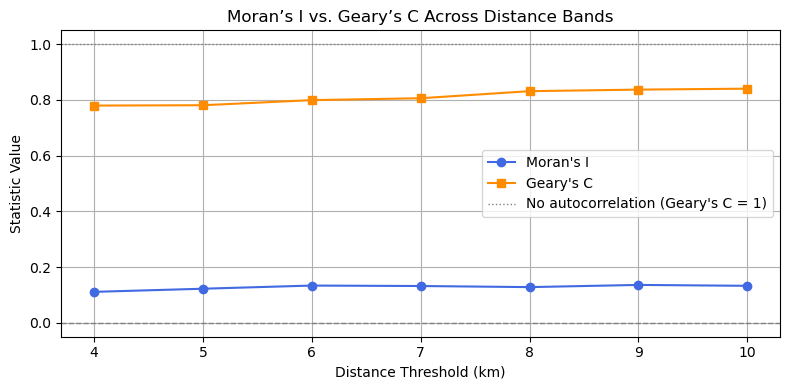

In [14]:
# Calculate Moran’s I across distance bands
from libpysal.weights import DistanceBand
from esda.moran import Moran
import matplotlib.pyplot as plt

distances_km = list(range(1, 11))
morans_I = []
p_values = []

for d in distances_km:
    print(f"Calculating Moran's I for {d} km...")
    w = DistanceBand.from_dataframe(gdf, threshold=d*1000, silence_warnings=True, binary=True)
    mi = Moran(gdf["lc1_num"], w, two_tailed=False)
    morans_I.append(mi.I)
    p_values.append(mi.p_sim)

# Calculate Geary's C across distance bands
from esda.geary import Geary

geary_C = []
geary_p = []

for d in distances_km:
    print(f"Calculating Geary's C for {d} km...")
    w = DistanceBand.from_dataframe(gdf, threshold=d*1000, silence_warnings=True, binary=True)
    gc = Geary(gdf["lc1_num"], w)
    geary_C.append(gc.C)
    geary_p.append(gc.p_sim)

plt.figure(figsize=(8, 4))

# Moran's I
plt.plot(distances_km, morans_I, marker='o', label="Moran's I", color='royalblue')

# Geary's C
plt.plot(distances_km, geary_C, marker='s', label="Geary's C", color='darkorange')

# Reference lines
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.axhline(1, color='gray', linestyle=':', linewidth=1, label="No autocorrelation (Geary's C = 1)")

plt.xlabel("Distance Threshold (km)")
plt.ylabel("Statistic Value")
plt.title("Moran’s I vs. Geary’s C Across Distance Bands")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

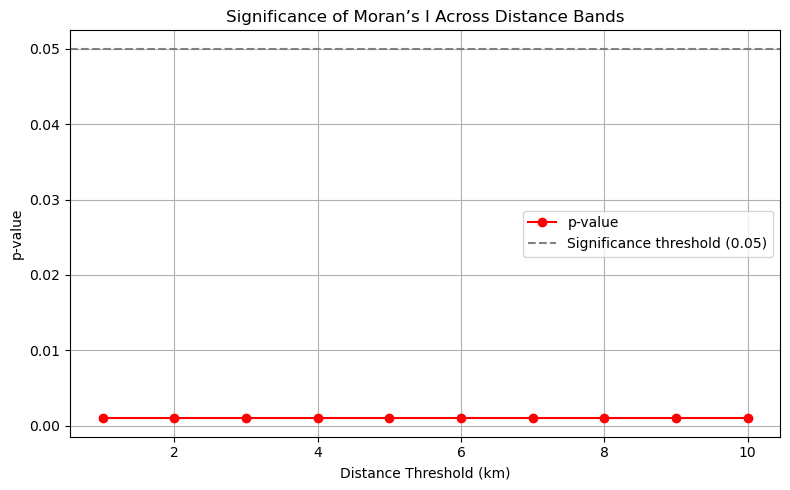

In [15]:
# Plotting p-values for Moran’s I
plt.figure(figsize=(8, 5))
plt.plot(distances_km, p_values, marker='o', color='red', label="p-value")
plt.axhline(0.05, color='gray', linestyle='--', label="Significance threshold (0.05)")
plt.xlabel("Distance Threshold (km)")
plt.ylabel("p-value")
plt.title("Significance of Moran’s I Across Distance Bands")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

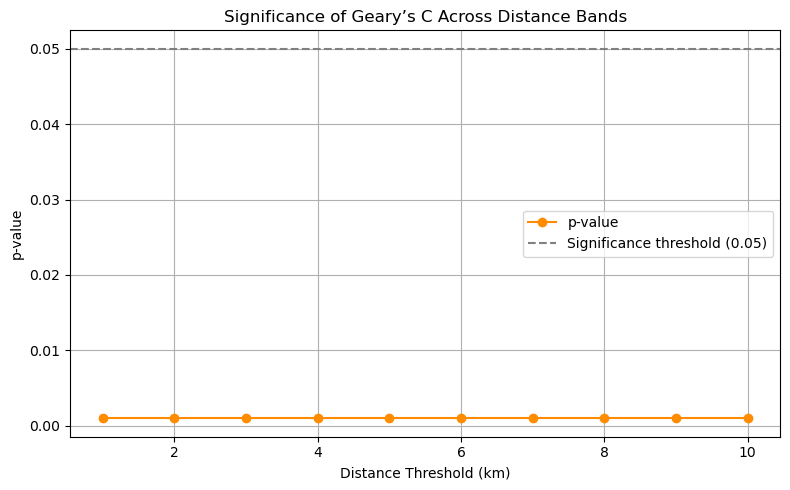

In [16]:
plt.figure(figsize=(8, 5))
plt.plot(distances_km, geary_p, marker='o', color='darkorange', label="p-value")
plt.axhline(0.05, color='gray', linestyle='--', label="Significance threshold (0.05)")
plt.xlabel("Distance Threshold (km)")
plt.ylabel("p-value")
plt.title("Significance of Geary’s C Across Distance Bands")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()